**Results for RWD experiments**

In [227]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np

In [228]:
mlflow.set_tracking_uri('http://localhost:3336')
client = MlflowClient()

model_names = ['Efficient', 'IPW', 'DR', 'Baseline_Minimax']
experiment_names = ['RWD_'+ model_name for model_name in model_names]
experiments = {exp.name: exp.experiment_id for exp in client.search_experiments()}

In [229]:
metric_names = ['regret']
param_names = ['global_seed', 'gamma', 'selection_bias']
data_dict = {}

for experiment_name in experiment_names:
    if experiment_name in experiments:
        experiment_id = experiments[experiment_name]
        # Get all runs for the experiment
        runs = client.search_runs(experiment_ids=[experiment_id])
        # Extract metrics and parameters
        runs_data = [
            {
                **run.data.metrics,
                **run.data.params,
                'run_id': run.info.run_id
            }
            for run in runs
        ]
        combined_df = pd.DataFrame(runs_data)
        
        if not combined_df.empty:
            # Filter the DataFrame to only include the desired metrics and parameters
            columns_to_include = ['run_id'] + metric_names + param_names
            filtered_df = combined_df[columns_to_include]
            data_dict[experiment_name.split("/")[0]] = filtered_df
        else:
            print(f"No runs found for experiment {experiment_name}.")
    else:
        print(f"Experiment {experiment_name} does not exist.")


efficient_estimator = data_dict['RWD_Efficient'].drop(columns=['run_id'])
efficient_estimator['regret'] = pd.to_numeric(efficient_estimator['regret'], errors='coerce')
efficient_estimator['gamma'] = pd.to_numeric(efficient_estimator['gamma'], errors='coerce')
efficient_estimator['selection_bias'] = pd.to_numeric(efficient_estimator['selection_bias'], errors='coerce')

baseline_minimax = data_dict['RWD_Baseline_Minimax'].drop(columns=['run_id'])
baseline_minimax['regret'] = pd.to_numeric(baseline_minimax['regret'], errors='coerce')
baseline_minimax['gamma'] = pd.to_numeric(baseline_minimax['gamma'], errors='coerce')
baseline_minimax['selection_bias'] = pd.to_numeric(baseline_minimax['selection_bias'], errors='coerce')

ipw_estimator = data_dict['RWD_IPW'].drop(columns=['run_id'])
ipw_estimator['regret'] = pd.to_numeric(ipw_estimator['regret'], errors='coerce')
ipw_estimator['selection_bias'] = pd.to_numeric(ipw_estimator['selection_bias'], errors='coerce')

dr_estimator = data_dict['RWD_DR'].drop(columns=['run_id'])
dr_estimator['regret'] = pd.to_numeric(dr_estimator['regret'], errors='coerce')
dr_estimator['selection_bias'] = pd.to_numeric(dr_estimator['selection_bias'], errors='coerce')

**Compute mean and standard deviation of regret over randomized policy** 

In [230]:
efficient_mean = efficient_estimator.groupby(['gamma', 'selection_bias'])['regret'].mean()
efficient_std = efficient_estimator.groupby(['gamma', 'selection_bias'])['regret'].std()
efficient_mean = efficient_mean.to_frame().reset_index()
efficient_mean['std'] = efficient_std.to_frame().reset_index()['regret'] / np.sqrt(10) # SE adjustmen

baseline_minimax_mean = baseline_minimax.groupby(['gamma', 'selection_bias'])['regret'].mean()
baseline_minimax_std = baseline_minimax.groupby(['gamma', 'selection_bias'])['regret'].std()
baseline_minimax_mean = baseline_minimax_mean.to_frame().reset_index()
baseline_minimax_mean['std'] = baseline_minimax_std.to_frame().reset_index()['regret'] / np.sqrt(10) # SE adjustmen

ipw_mean = ipw_estimator['regret'].mean()
ipw_std = ipw_estimator['regret'].std() / np.sqrt(10) # SE adjustmen
dr_mean = dr_estimator['regret'].mean()
dr_std = dr_estimator['regret'].std() / np.sqrt(10) # SE adjustmen


**Plot the results**

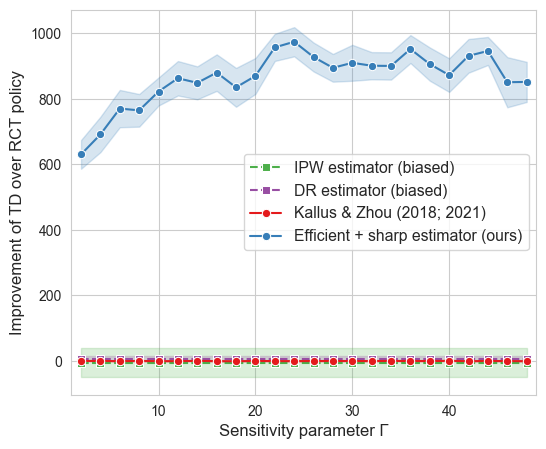

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set1", n_colors=4)

gamma_values = np.arange(2, 50, 2)  # 2, 4, 6, ..., 48

biased_baslines = pd.DataFrame({'gamma': gamma_values,
                                'regret_ipw': ipw_mean,
                                'regret_dr': dr_mean,
                                'std_ipw': ipw_std,
                                'std_dr': dr_mean})



# Create the plot
plt.figure(figsize=(6, 5))

# IPW
sns.lineplot(data=biased_baslines, x='gamma', y='regret_ipw', marker='s', linestyle='dashed', label="IPW estimator (biased)", color=palette[2])
plt.fill_between(biased_baslines['gamma'], 
                     biased_baslines['regret_ipw'] - biased_baslines['std_ipw'], 
                     biased_baslines['regret_ipw'] + biased_baslines['std_ipw'], 
                     alpha=0.2,color=palette[2])

# DR
sns.lineplot(data=biased_baslines, x='gamma', y='regret_dr', marker='s', linestyle='dashed', label="DR estimator (biased)", color=palette[3])
plt.fill_between(biased_baslines['gamma'], 
                     biased_baslines['regret_dr'] - biased_baslines['std_dr'], 
                     biased_baslines['regret_dr'] + biased_baslines['std_dr'], 
                     alpha=0.2, color=palette[3])

# Minimax baseline
sns.lineplot(data=baseline_minimax, x='gamma', y='regret', marker='o', label='Kallus & Zhou (2018; 2021)', color=palette[0])
plt.fill_between(efficient['gamma'], 
                     baseline_minimax['regret'] - baseline_minimax['std'], 
                     baseline_minimax['regret'] + baseline_minimax['std'], 
                     alpha=0.2, color=palette[0])


# Efficient
sns.lineplot(data=efficient, x='gamma', y='regret', marker='o', label='Efficient + sharp estimator (ours)', color=palette[1])
plt.fill_between(efficient['gamma'], 
                     efficient['regret'] - efficient['std'], 
                     efficient['regret'] + efficient['std'], 
                     alpha=0.2, color=palette[1])


# Set title and labels
plt.xlim(1,49)
plt.xlabel("Sensitivity parameter Г", fontsize=12)  # Uncomment if you want to display the label
plt.ylabel("Improvement of TD over RCT policy", fontsize=12)  # Uncomment if you want to display the label
plt.legend(loc='center right', frameon=True, fontsize=11.3)

# Show plot
plt.show()